In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

# Part 1 - Object Blending

### Sliding Window Object for Bilinear Kernel

### Sobel and Gaussian Kernels

In [29]:

# Sliding window
def sliding_window(image, n, s, show=False):
    height, width = image.shape[0:2]
    
    for i in range(0, height-n+1, s):
        for j in range(0, width-n+1, s):
            if show:
                yield (j, i, j+n, i+n) # Used to plot rectangle
            elif show==False:
                yield image[i:i+n, j:j+n] # Current image region

# Generate a sobel kernel of n*n dimension
def gen_sobel(n, trans=False):
    sobel = np.zeros((n,n)) # initial array of 0s
    centre = n/2 - 0.5
    for i in range(n):
        for j in range(n):
            # Skips the middle pixel (which is always 0) 
            # to avoid divide by 0 errors
            if i==centre and j==centre:
                continue
                
            x = i - centre # x distance from centre
            y = j - centre # y distance from centre
            sobel[j, i] = x / (x*x + y*y) 
    if trans: return np.transpose(sobel)
    return sobel

# Generating Gaussian kernel
def gen_gaussian(size, fwhm = 10, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size // 2 # Centre is identified as the centre pixel
    else:
        x0 = center[0]
        y0 = center[1]
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2) # Gaussian equation


def convolve(region, kernel):
    # Valid region and filter dimensions
    if region.shape[0] == region.shape[1] == kernel.shape[0] == kernel.shape[1]:
        pix = [sum(sum(region[:, :, i]*kernel)) for i in range(3)] # Convolution operation
        return pix
    else:
        raise Exception('Invalid kernel and/or region sizes')

# Convolution logic and display before and after pics

def convolve_image(image, kernel, stride):
    
    n = kernel.shape[0]
    img_height, img_width = image.shape[0:-1]
    
    # New height and width of convolution output
    width = int((img_width - n) / stride) +1 
    height = int((img_height - n) / stride)+1
    
    convolved_img = np.zeros((height, width, 3))
    regions = list(sliding_window(image, n, stride))
    
    # Populating output with convolved pixel values
    count=0
    for i in range(height):
        for j in range(width):
            convolved_img[i][j] = convolve(regions[count], kernel)
            count+=1
    
    # Convolved image output pixels are normalised between 0 and 255 and converted to integer
    norm = np.zeros((1,1))
    return cv2.normalize(convolved_img, norm, 0, 255, cv2.NORM_MINMAX).astype(int)

#sobel_x_img = convolve_image(img, gen_sobel(3), 1)
#sobel_y_img = convolve_image(img, gen_sobel(3, True), 1)

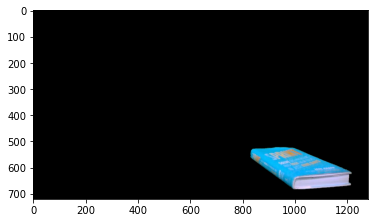

In [30]:
S2 = cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/2_colour.jpeg')
mask = cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/masks/ac_3_colour_mask_8_mask.png')


extracted = ExtractObject(S2, mask)
plt.imshow(extracted[:,:,::-1])

## Functions for Object Blending

In [31]:
def ExtractObject(S2, Mask):
    return cv2.bitwise_and(S2, Mask)

def ApplyFilter(Object, Filter):
    
    if Filter == 0:
        return Object
    elif Filter == 1:
        # Sobel X
        #return convolve_image(Object, gen_sobel(3, False), 1)
        kernel = gen_sobel(3,True)
    elif Filter == 2:
        # Gaussian
        #return convolve_image(Object, gen_gaussian(10), 3)
        kernel = gen_gaussian(13)
        kernel = kernel*1/np.sum(kernel) # normalize kernel values
    elif Filter == 3:
        #Bilinear
#         bilinear = Bilinear(1/10)
#         FilteredObject = bilinear.FilterImage(Object, axis=0)
#         return FilteredObject
        kernel = np.array([[1,2,1],
                 [2,4,2],
                 [1,2,1]]) * (1/16)
    else:
        print("[ERR]Incorrect Input")
        return 0
    
    return cv2.filter2D(Object,-1, kernel)

def ObjectBlender(S1, FilteredExObject):
    gray = cv2.cvtColor(FilteredExObject, cv2.COLOR_BGR2GRAY)
    #cv2.imwrite("Testing/gray.png", gray, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    ret,mask = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    #cv2.imwrite("Testing/mask.png", mask, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    #cv2.imwrite("Testing/newmask.png", mask [cv2.IMWRITE_PNG_COMPRESSION, 0])
    background = cv2.bitwise_and(S1, cv2.bitwise_not(mask))
    #cv2.imwrite("Testing/background.png", background, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    return FilteredExObject+background
    
def CompareResult(BlendingResult, S2, metric):
    if metric == "SSD":
        dif = BlendingResult.ravel() - S2.ravel()
        return np.dot(dif, dif)
    elif metric == "MSE":
        return np.square(np.subtract(BlendingResult,S2)).mean()
    
    print("[ERR]Incorrect metric")
    return -1

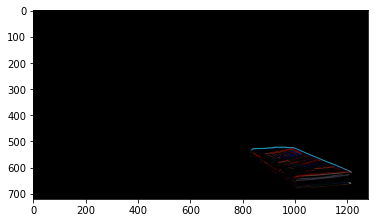

In [33]:
filteredImg = ApplyFilter(extracted, 1)
plt.imshow(filteredImg[:,:,::-1])

(720, 1280, 3)


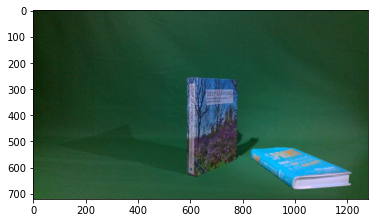

In [11]:
S1 = cv2.imread('COTSDataset/Part 2 - Multiple Objects/academic_book_no/1_colour.jpeg')
print(S1.shape)
blend = ObjectBlender(S1, extracted)
cv2.imwrite("Testing/blend.png", blend, [cv2.IMWRITE_PNG_COMPRESSION, 0])
plt.imshow(blend[:,:,::-1])

### SSD - Sum of Square Differences 

In [28]:
print("SSD of Blend and S2: ", CompareResult(blend, S2, 'SSD'))

SSD of Blend and S2:  201


### MSE - Mean Squared Error

In [27]:
print("MSE of Blend and S2: ", CompareResult(blend, S2, 'MSE'))

MSE of Blend and S2:  15.514517144097223


### Removing Green Background from Image

## Chroma Keying

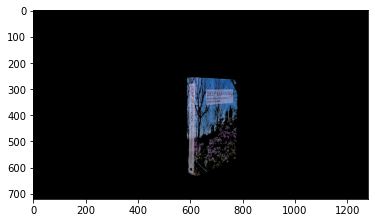

In [24]:
testing = cv2.imread('COTSDataset/Part 2 - Multiple Objects/footwear_no/1_colour.jpeg')
def RemoveGreen(img):
    
    lower_green = np.array([0, 0, 0]) 
    upper_green = np.array([104, 153, 70])
    
    mask = cv2.inRange(img, lower_green, upper_green)
    skd = np.copy(img)
    skd[mask!=0] = [0,0,0]
    
    return skd

shoe = RemoveGreen(testing)
masked = RemoveGreen(S1)
plt.imshow(masked[:,:,::-1])

In [13]:
MSE = np.square(np.subtract(blend,S2)).mean()
print("MSE of Blend and S2: ", MSE)

MSE of Blend and S2:  15.514517144097223


### Blending Extracted Image to a New Background

In [22]:
def NewBackground(imgNoBg, NewBackground):
    final = ObjectBlender(NewBackground, imgNoBg)
    #plt.imshow(final)
    return final

### Application
Iterating through all of the backgrounds and blending with the extracted image.

In [25]:
for x in os.listdir("ResizedBGS"):
    image = cv2.imread("ResizedBGS/" + x)
    final = NewBackground(testing, image)
    #cv2.imshow("Output", final)
    cv2.imwrite("Output/greenv" + x, final)